# Data Cleaning

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns
from scipy.stats import mode
from functools import reduce
from pykalman import KalmanFilter
import pmdarima as pm

ImportError: cannot import name 'huber_loss' from 'sklearn.metrics' (/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [20]:
DGS1 = pd.read_excel("DATA/DGS1.xls", skiprows=10)
DGS2 = pd.read_excel("DATA/DGS2.xls", skiprows=10)
DGS3MO   = pd.read_excel("DATA/DGS3MO.xls", skiprows=10)
DGS6MO  = pd.read_excel("DATA/DGS6MO.xls", skiprows=10)
DGS10= pd.read_excel("DATA/DGS10.xls", skiprows=10)
DGS3 = pd.read_excel("DATA/DGS3.xls", skiprows=10)
DGS5= pd.read_excel("DATA/DGS5.xls", skiprows=10)
DGS7= pd.read_excel("DATA/DGS7.xls", skiprows=10)

#Drop the 0 columns
DGS1 = DGS1[(DGS1 != 0.00).all(axis=1)]
DGS2 = DGS2[(DGS2 != 0.00).all(axis=1)]
DGS3MO = DGS3MO[(DGS3MO != 0.00).all(axis=1)]
DGS6MO = DGS6MO[(DGS6MO != 0.00).all(axis=1)]
DGS10 = DGS10[(DGS10 != 0.00).all(axis=1)]
DGS3 = DGS3[(DGS3 != 0.00).all(axis=1)]
DGS5 = DGS5[(DGS5 != 0.00).all(axis=1)]
DGS7 = DGS7[(DGS7 != 0.00).all(axis=1)]

In [21]:
index_comparison = {
    'DGS2': set(DGS1.index) == set(DGS2.index),
    'DGS3MO': set(DGS1.index) == set(DGS3MO.index),
    'DGS6MO': set(DGS1.index) == set(DGS6MO.index),
    'DGS10': set(DGS1.index) == set(DGS10.index),
    'DGS3': set(DGS1.index) == set(DGS3.index),
    'DGS5': set(DGS1.index) == set(DGS5.index),
    'DGS7': set(DGS1.index) == set(DGS7.index),
}

for df_name, comparison_result in index_comparison.items():
    print(f"{df_name} has the same indices as DGS1: {comparison_result}")


DGS2 has the same indices as DGS1: True
DGS3MO has the same indices as DGS1: False
DGS6MO has the same indices as DGS1: True
DGS10 has the same indices as DGS1: True
DGS3 has the same indices as DGS1: True
DGS5 has the same indices as DGS1: True
DGS7 has the same indices as DGS1: True


In [22]:
# Assume df1, df2, df3, ... are DataFrame objects you want to merge
dataframes = [DGS3MO, DGS1, DGS2, DGS6MO, DGS10, DGS3, DGS5, DGS7]

# Using reduce to merge multiple DataFrames on a common key
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date'), dataframes)

In [23]:
merged_df

,observation_date,DGS3MO,DGS1,DGS2,DGS6MO,DGS10,DGS3,DGS5,DGS7
0,2014-01-02,0.07,0.13,0.39,0.09,3.00,0.76,1.72,2.41
1,2014-01-03,0.07,0.13,0.41,0.10,3.01,0.80,1.73,2.42
2,2014-01-06,0.05,0.12,0.40,0.08,2.98,0.78,1.70,2.38
3,2014-01-07,0.04,0.13,0.40,0.08,2.96,0.80,1.69,2.37
4,2014-01-08,0.05,0.13,0.43,0.08,3.01,0.87,1.77,2.44
...,...,...,...,...,...,...,...,...,...
2517,2024-02-13,5.45,4.99,4.64,5.32,4.31,4.44,4.31,4.33
2518,2024-02-14,5.43,4.94,4.56,5.31,4.27,4.38,4.25,4.27
2519,2024-02-15,5.43,4.93,4.56,5.30,4.24,4.36,4.22,4.25
2520,2024-02-16,5.44,4.98,4.64,5.31,4.30,4.43,4.29,4.31


In [24]:
time_period = merged_df.iloc[:,0].values

# Task B

Formulating Curve Fitting Problem

In [54]:


# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

# Initialize a dictionary to hold the results
results = {}

# Your NS_model definition remains the same

# When calling curve_fit, add the bounds argument
# Set the bounds for [beta_0, beta_1, beta_2, lambda]
# Assuming you want all parameters to be free but lambda to be strictly positive,
# you can set the lower bounds for all parameters to -np.inf (or a sensible lower limit for each)
# and set the lower bound for lambda to a small positive number (e.g., 1e-6 to avoid zero and enforce positivity)
# Upper bounds are set to np.inf, which means no upper limit (or you can specify a sensible upper limit)

bounds = ([-np.inf, -np.inf, -np.inf, 1e-6], [np.inf, np.inf, np.inf, np.inf])

# Now include these bounds in your curve_fit call
params, _ = curve_fit(NS_model, x_data, y_data, bounds=bounds, maxfev=10000)


# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    initial_guess = [1.0, 0.5, 0.3, 0.4]
    
    # Apply curve fit
    params, _ = curve_fit(NS_model, x_data, y_data , p0=initial_guess ,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.10598402e+00 -2.34909657e+00  2.73864458e-04  3.64483192e-01]
  MAE: 0.5387157543892022
  MSE: 0.5916201844605915
  R2: 0.49355649176303196

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.11075092e+00 -2.36280604e+00  6.04174689e-04  3.74052363e-01]
  MAE: 0.5361672433154935
  MSE: 0.5840199598429894
  R2: 0.5004740706049231

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.06905701e+00 -2.33776313e+00  4.15800647e-04  3.80098449e-01]
  MAE: 0.5320350924935652
  MSE: 0.5783296031824452
  R2: 0.49800432914821813

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.06086382e+00 -2.33289814e+00  1.96013285e-04  3.82785252e-01]
  MAE: 0.5244945119744582
  MSE: 0.564779494707701
  R2: 0.5030475291668965

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.15385740e+00 -2.42059129e+00 -2.76662142e-04  3.71265761e-01]
  MAE: 0.5246015348078447
  MSE: 0.5712054433566849
  R2: 0.5178760046155126

5:
  Parameters (beta_0,beta_1,beta_2, lmbda

In [55]:
lambdas = [value['Parameters'][3] for value in results.values()]
beta_0 = [value['Parameters'][0] for value in results.values()]
beta_1 = [value['Parameters'][1] for value in results.values()]
beta_2 = [value['Parameters'][2] for value in results.values()]
#sns.distplot(lambdas, bins=1000)

In [57]:
np.min(lambdas)

-1.651179363088646e-05

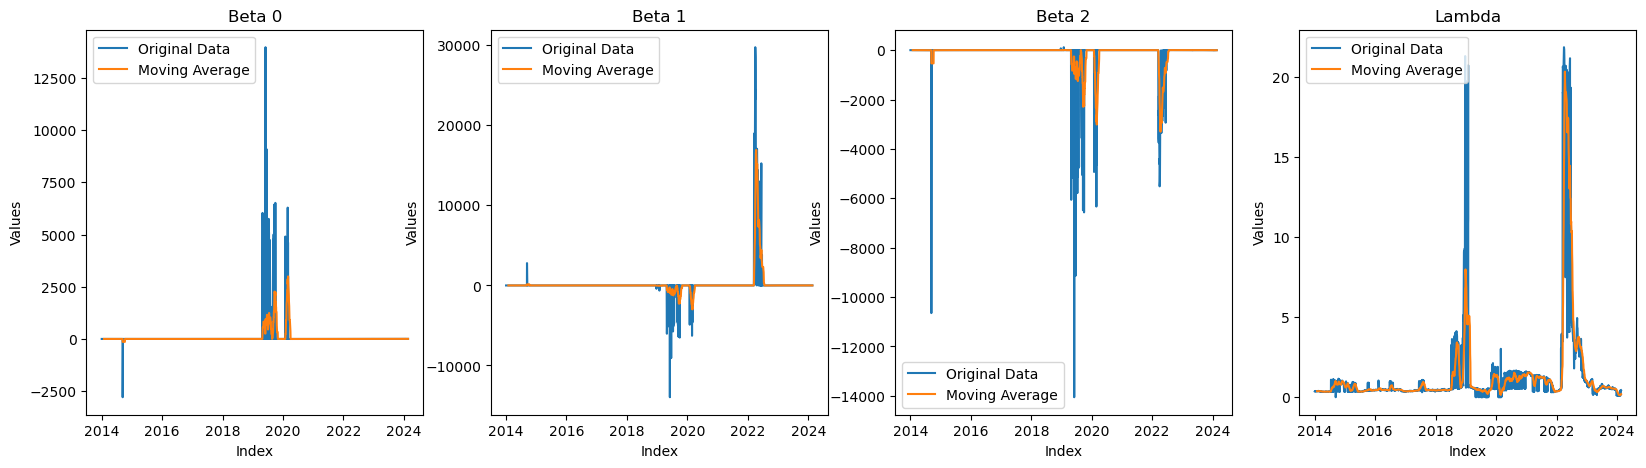

In [58]:
def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    plt.subplot(1, 4, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(beta_0, 1, 'Beta 0')
plotting_param(beta_1, 2, 'Beta 1')
plotting_param(beta_2, 3, 'Beta 2')  # Assuming you have beta_3
plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()


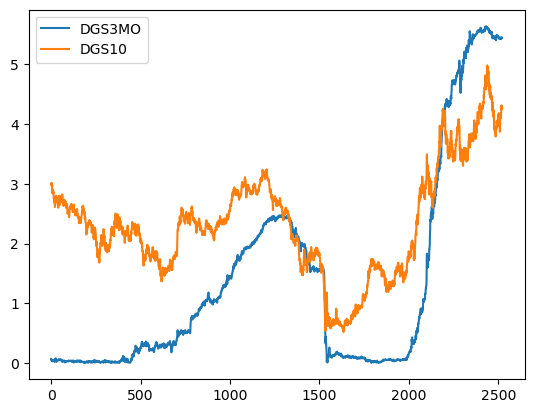

In [59]:
#merged_df.set_index('observation_date', inplace=True)
merged_df["DGS3MO"].plot()
#merged_df["DGS6MO"].plot()
#merged_df["DGS1"].plot()
#merged_df["DGS2"].plot()
#merged_df["DGS3"].plot()
#merged_df["DGS5"].plot()
#merged_df["DGS7"].plot()
merged_df["DGS10"].plot()
plt.legend()

Finding the optimal lambda with  time-series-crossvalidation

1. What is our loss function
2. How do we cross validate in time series
3. compare cross-validation against vanilla method


In [77]:
rounded_lambdas =  [round(num, 2) for num in lambdas]
len(set(rounded_lambdas))
possible_values = []
for i in set(rounded_lambdas):
    if i > 5.0 and i < 10 :
        possible_values.append(i)

In [78]:
possible_values

[5.1,
 6.48,
 9.11,
 9.3,
 6.5,
 7.5,
 9.71,
 6.22,
 8.72,
 5.19,
 6.94,
 7.41,
 7.91,
 7.16,
 8.66,
 6.1,
 6.26,
 6.23,
 5.14,
 5.89,
 9.86,
 5.61,
 6.61,
 5.55,
 6.27,
 7.49,
 5.21,
 5.15,
 8.62,
 5.87,
 5.37]

Try to design a systematic trading strategy based on the NS model. This is an open ended project and sky is the limit. It could, for exam- ple, go along the following lines.
(i) Calibrate the NS model for each of the days in your database, store the daily values of the parameters β1, β2, β3 and λ.

In [79]:
# Assuming NS_model is defined elsewhere
# Assuming results, merged_df, and rounded_lambdas are defined elsewhere

# Initialize a dictionary to hold the results
op_lam = {}
min_mse = float('inf')  # Using float('inf') is a more conventional way to initialize to infinity
min_mae = float('inf')
min_r2 = float('inf')

for lambda_opt in tqdm(possible_values, desc="Optimizing Lambda"):
    mae = 0
    mse = 0
    r2 = 0
    huber_loss_accumulated = 0
    for row in range(len(merged_df)):  # Assuming merged_df is defined elsewhere
        y_data = merged_df.iloc[row].values[1:]
        x_data = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])
        
        # Apply curve fit and predict (assuming NS_model and results are correctly defined)
        y_pred = NS_model(x_data, results[row]['Parameters'][0], results[row]['Parameters'][1], results[row]['Parameters'][2], lambda_opt)
        
        # Calculate metrics
        mae += mean_absolute_error(y_data, y_pred)
        mse += mean_squared_error(y_data, y_pred)

    # Update minimum metrics and corresponding lambda
    if mse < min_mse:
        op_lam["mse"] = lambda_opt
        min_mse = mse
    if mae < min_mae:
        op_lam["mae"] = lambda_opt
        min_mae = mae
    
    

print(op_lam)


Optimizing Lambda: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:18<00:00,  1.68it/s]

{'mse': 5.21, 'mae': 7.91}


In [76]:
op_lam

{'mse': 5.2, 'mae': 7.9}

In [81]:
op_lam_mse = 5.21

In [80]:
op_lam_mae = 7.81

Part B (ii) and (iii): Optimal Parameter Fitting for beta_0, beta_1 and beta_2

In [82]:


# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

def NS_model_lambda_fixed(s, beta_0,beta_1,beta_2):
    return beta_0 + beta_1 * np.exp(-op_lam_mse*s) + beta_2*op_lam_mse*s*np.exp(-op_lam_mse*s)

# Initialize a dictionary to hold the results
fix_lambda_results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model_lambda_fixed, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model_lambda_fixed(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    fix_lambda_results[row] = {
        'Parameters': params,
        'lambda': -1.08,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in fix_lambda_results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  lambda: {metrics['lambda']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.46705757  10.49412288 -11.90963774]
  lambda: -1.08
  MAE: 0.7272663708437225
  MSE: 0.7945451516408157
  R2: 0.31984701567183893

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.48402076  10.57996241 -12.02409636]
  lambda: -1.08
  MAE: 0.7217261186725259
  MSE: 0.7869801134135976
  R2: 0.3268775048817548

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.45798916  10.36727159 -11.84515214]
  lambda: -1.08
  MAE: 0.7155747613296435
  MSE: 0.7764000490641207
  R2: 0.32607727265805264

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.45407007  10.13219278 -11.68191309]
  lambda: -1.08
  MAE: 0.7084804286841444
  MSE: 0.7631257996176677
  R2: 0.32852156420310497

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.50621147  10.56832906 -12.13435444]
  lambda: -1.08
  MAE: 0.7200570745205057
  MSE: 0.7858770867730881
  R2: 0.33668314025577717

5:
  Parameters (beta_0,beta_1,beta_2, lmbda): [  1.48624003  10.29009055 -11.89537593

In [103]:

#lambdas = [value['Parameters'][3] for value in results.values()]
fix_beta_0 = [value['Parameters'][0] for value in fix_lambda_results.values()]
fix_beta_1 = [value['Parameters'][1] for value in fix_lambda_results.values()]
fix_beta_2 = [value['Parameters'][2] for value in fix_lambda_results.values()]
#sns.distplot(lambdas, bins=1000)

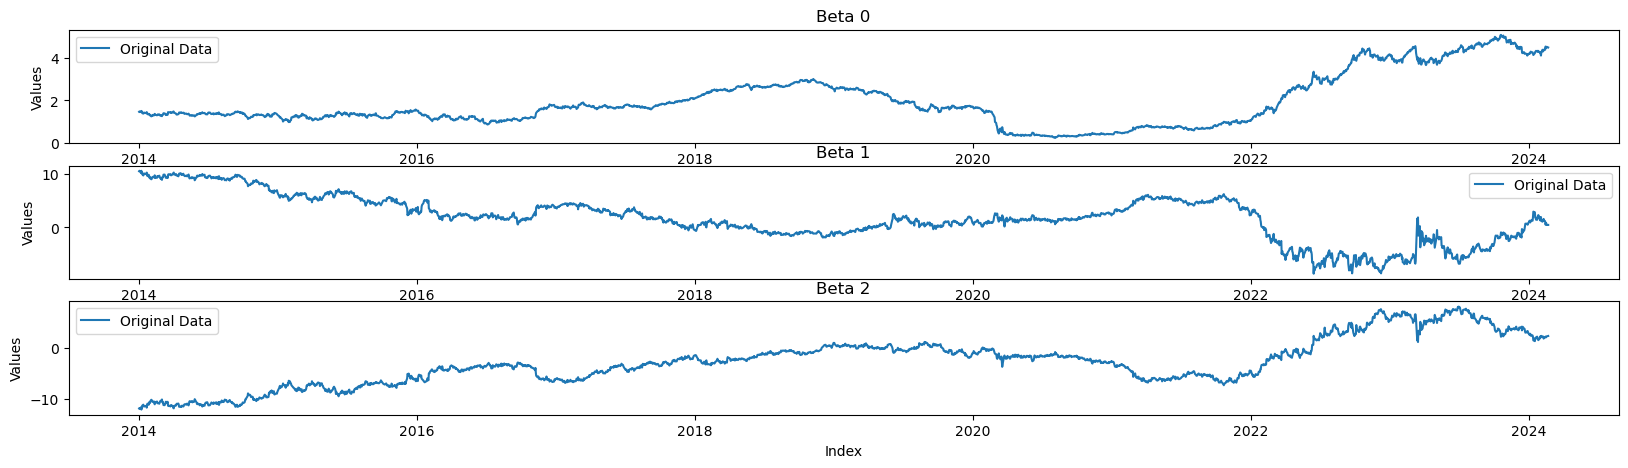

In [104]:


# Define the time range from the given start and end dates
#time_period


def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    #moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    lambdas_series = pd.Series(list_plot, index=time_period)
    plt.subplot(3, 1, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    #plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')
    

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(fix_beta_0, 1, 'Beta 0')
plotting_param(fix_beta_1, 2, 'Beta 1')
plotting_param(fix_beta_2, 3, 'Beta 2')  # Assuming you have beta_3
plt.show()

## Calibration for the lambda model

In [85]:
lambdas

[0.36448319224456666,
 0.3740523632279524,
 0.38009844882873733,
 0.3827852520271077,
 0.37126576061852384,
 0.36794705009718015,
 0.3800924713807383,
 0.39191574169756893,
 0.3800672706642609,
 0.37477028517107325,
 0.37997425105473637,
 0.3826364429945354,
 0.37813605167452935,
 0.36965956960473845,
 0.37160674085226286,
 0.3779298854702717,
 0.36973920423854634,
 0.37739498426445844,
 0.3828599697167493,
 0.3773992417328413,
 0.38717776814002147,
 0.3783714392476303,
 0.37595275503518805,
 0.3702202384604242,
 0.3739737002130712,
 0.38580068715488897,
 0.39054803024886714,
 0.3910086046084935,
 0.38496995498380143,
 0.39442726850054816,
 0.3964587938594274,
 0.38522535882903153,
 0.38237011508794,
 0.3779782993593591,
 0.36972859747075937,
 0.37650843024762687,
 0.376834970596647,
 0.384060216752704,
 0.3815073812048266,
 0.37378943115025903,
 0.37937510005575487,
 0.37001111130170783,
 0.37360053533021537,
 0.3758846738471209,
 0.36574602104494935,
 0.367311471261024,
 0.3656152192

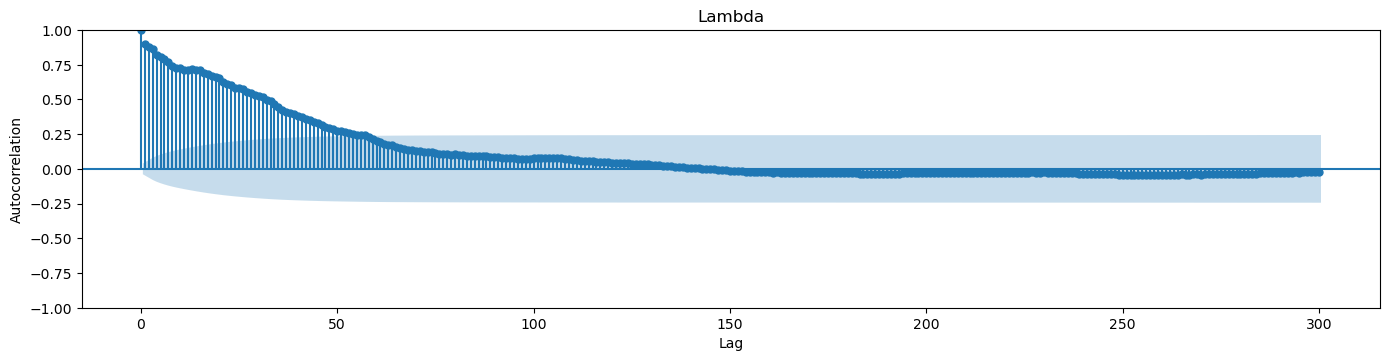

In [93]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(lambdas, 1, 'Lambda')
#plotting_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

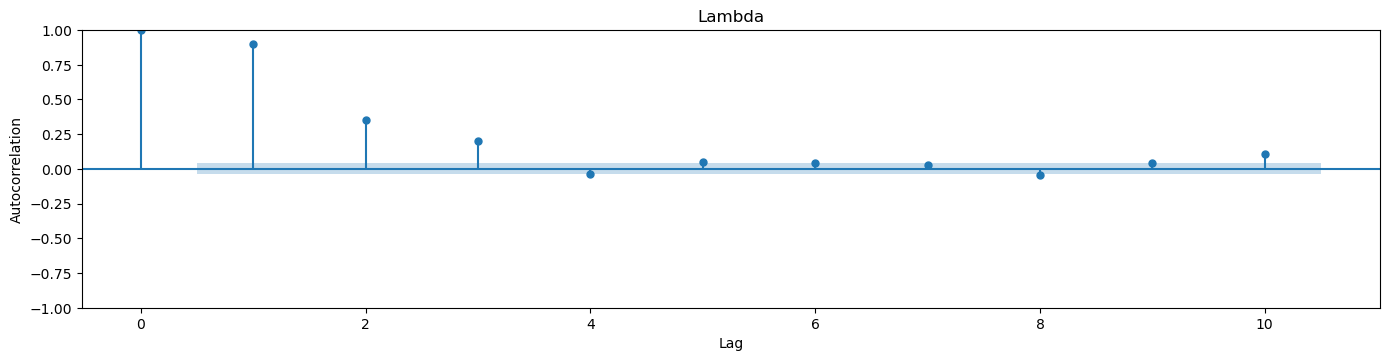

In [94]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=10, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(lambdas, 1, 'Lambda')
#plotting_partial_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_partial_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# PMD Auto Arima for Lambdas

In [109]:
arima_model_lambdas = pm.auto_arima(lambdas, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='bic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=8600.254, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=8088.018, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=8090.015, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=8090.130, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=8040.711, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=8042.654, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=8200.507, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=8090.015, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=8067.873, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=8068.258, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=8042.615, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=8075.142, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=8075.599, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=8070.648, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=8070.571, Time=0.65 sec
 ARIMA(3,1

In [111]:
arima_model_lambdas = pm.auto_arima(fix_beta_0, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-8464.827, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-8463.728, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-8463.368, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-8461.467, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-8464.033, Time=0.70 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-8463.499, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-8463.680, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-8461.111, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-8460.267, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-8459.505, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-8462.774, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-8463.473, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-8460.787, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-8480.687, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-8477.803, Time=0.96

In [110]:
arima_model_lambdas = pm.auto_arima(fix_beta_1, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2147.635, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2080.780, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2082.729, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2060.375, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2043.943, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2034.445, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2080.213, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2082.207, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2083.805, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2051.785, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2017.171, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2082.210, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2065.337, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2076.968, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2056.782, Time=1.07 sec
 ARIMA(3,1

In [108]:
arima_model_lambdas = pm.auto_arima(fix_beta_2, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=781.736, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=751.135, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=751.798, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=736.199, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=727.541, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=728.370, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=749.646, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=749.626, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=751.590, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=728.329, Time=0.69 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=716.602, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=750.290, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=751.606, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=740.302, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=730.218, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[1] i

<Axes: >

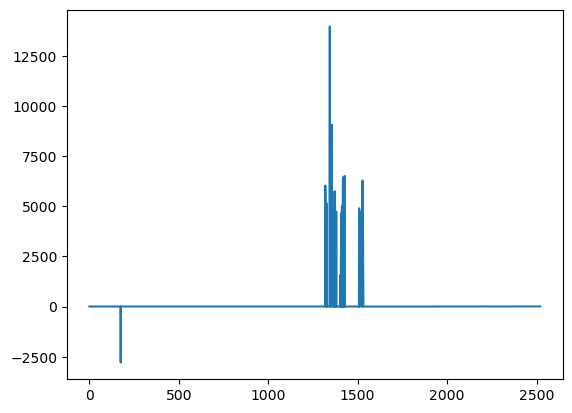

In [102]:
pd.Series(beta_0).plot()

# Checking statistical topics and applying various time series model for each parameter

(ii) Investigate the statistical properties of the time series of these pa- rameters. Do they show any mean reversion properties, can they be modeled by any of the time series models (such as ARIMA)?

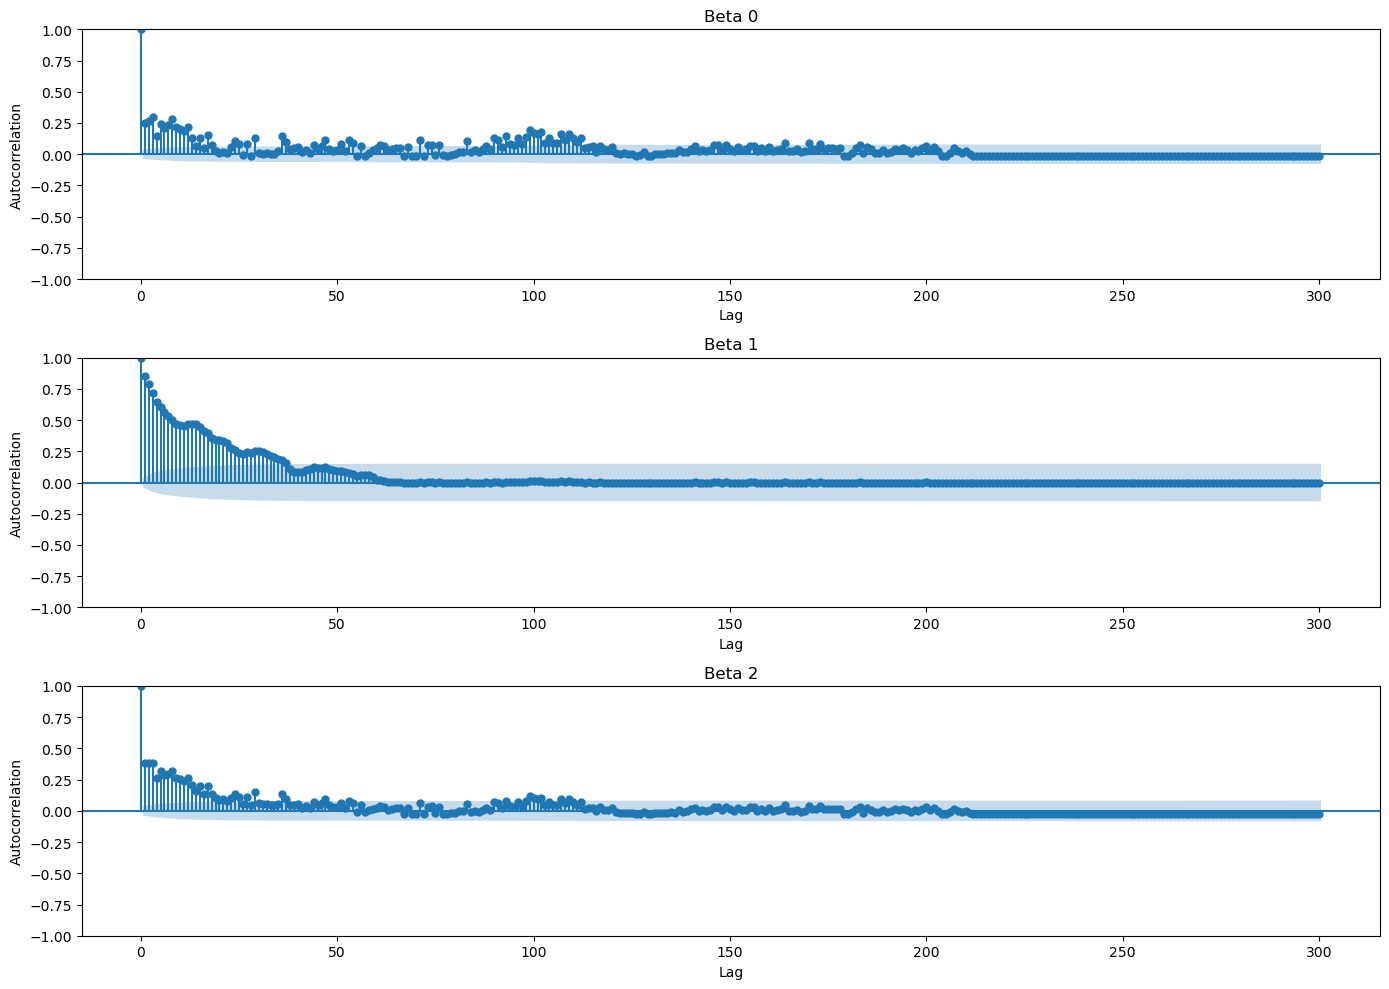

In [112]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(beta_0, 1, 'Beta 0')
plotting_auto_correlation(beta_1, 2, 'Beta 1')
plotting_auto_correlation(beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

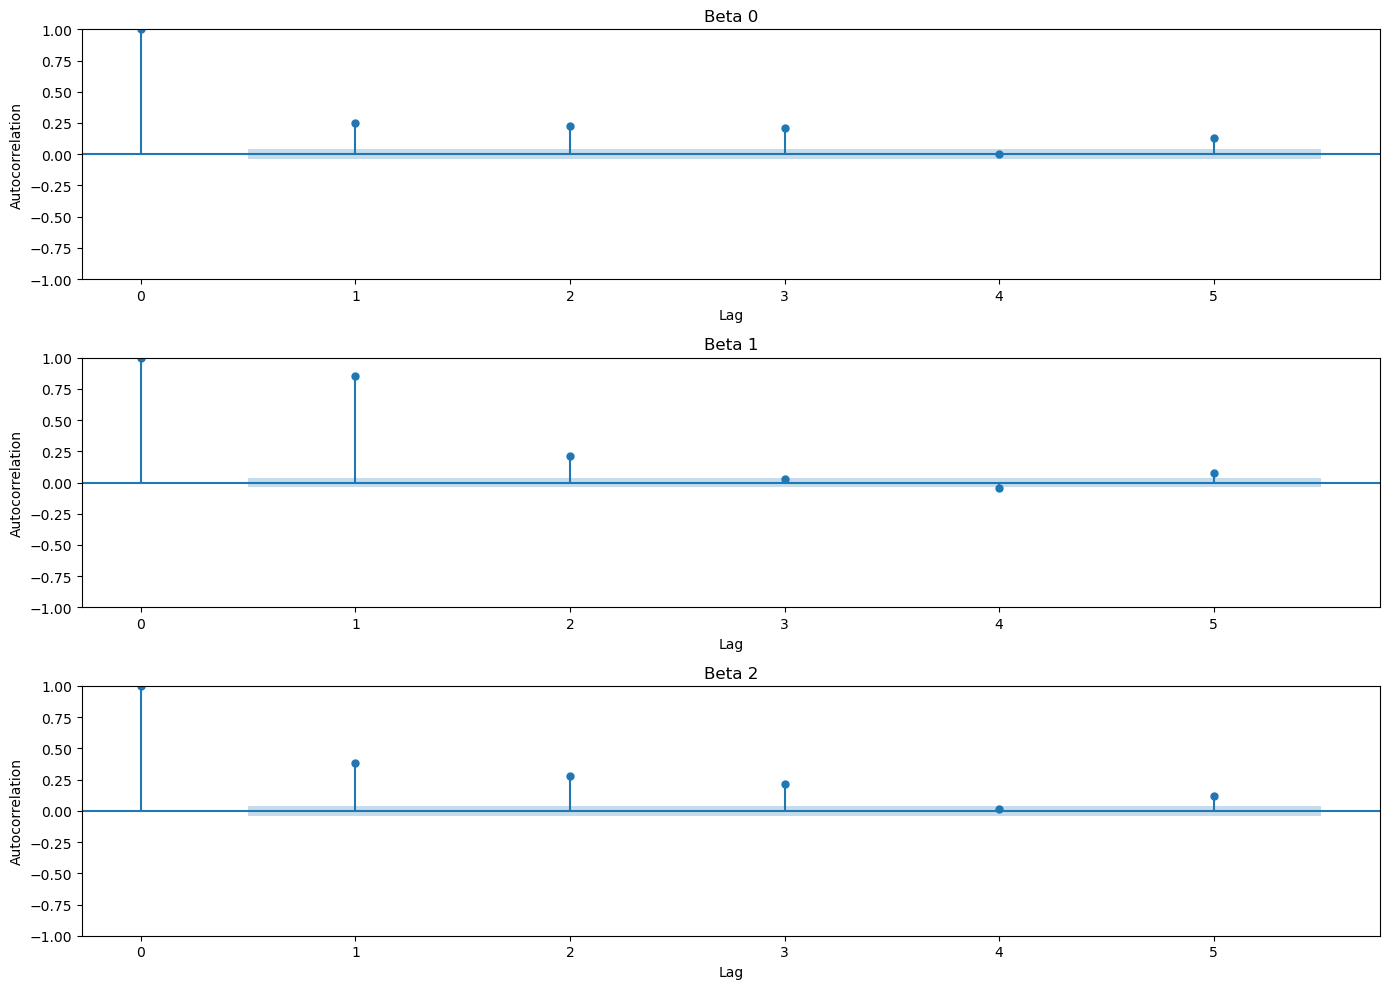

In [113]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=5, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(beta_0, 1, 'Beta 0')
plotting_partial_auto_correlation(beta_1, 2, 'Beta 1')
plotting_partial_auto_correlation(beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [114]:

def check_mean_reversion(series, name):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("The series " + name + " is likely mean-reverting.")
    else:
        print("The series " + name + " is not likely mean-reverting.")

# Assume 'time_series' is your pandas Series
check_mean_reversion(beta_0, "beta 0")
check_mean_reversion(beta_1, "beta 1")
check_mean_reversion(beta_2, "beta 2")

ADF Statistic: -6.732613
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 0 is likely mean-reverting.
ADF Statistic: -5.782901
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 1 is likely mean-reverting.
ADF Statistic: -6.638144
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 2 is likely mean-reverting.


# stationarity

In [115]:

# Assuming 'time_series' is your pandas Series
def check_stationarity(ts,name):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(ts, autolag='AIC')  # AIC is used to select the best lag length
    
    result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        result['Critical Value (%s)' % key] = value
        
    print(result)
    
    # Interpretation
    if result['p-value'] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# Assume 'time_series' is your pandas Series
check_stationarity(beta_0, "beta 0")
check_stationarity(beta_1, "beta 1")
check_stationarity(beta_2, "beta 2")

Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.732613e+00
p-value                        3.267030e-09
#Lags Used                     2.600000e+01
Number of Observations Used    2.495000e+03
Critical Value (1%)           -3.432974e+00
Critical Value (5%)           -2.862699e+00
Critical Value (10%)          -2.567387e+00
dtype: float64
The series is likely stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.782901e+00
p-value                        5.077071e-07
#Lags Used                     2.600000e+01
Number of Observations Used    2.495000e+03
Critical Value (1%)           -3.432974e+00
Critical Value (5%)           -2.862699e+00
Critical Value (10%)          -2.567387e+00
dtype: float64
The series is likely stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.638144e+00
p-value                        5.495812e-09
#Lags Used                     2.600000e+01
Number of Observations Used    2.

# Optimal Lambda

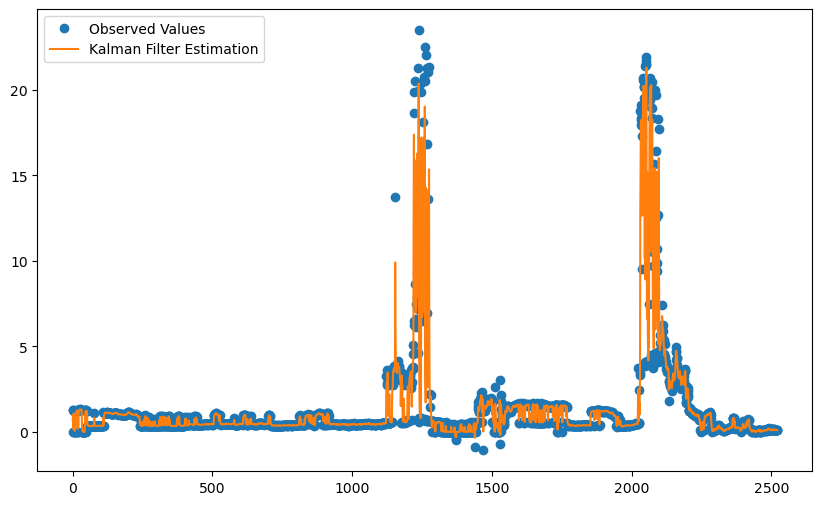

Next value prediction: 0.10283523409594805


0.4946521808603733

In [37]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate the hidden states
state_means, state_covariances = kf.filter(lambdas)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(lambdas, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], lambdas[1:])

In [38]:
lambdas

[1.2776861232438654,
 1.2743907248426598,
 -1.5120429650250185e-05,
 -8.053034779743625e-06,
 1.2377160986385198,
 1.221682459580831,
 -9.454951489903341e-06,
 -8.22976502357095e-06,
 -9.129443362075955e-06,
 1.2405072818802227,
 1.2492281405829808,
 -1.5009467393748321e-05,
 1.2434265962272664,
 1.2181730250027392,
 1.243879502560331,
 1.2584248885583977,
 1.2589886529201917,
 -1.7058913475694844e-05,
 -1.742142176410552e-05,
 1.2588631409615323,
 -1.6596980796903456e-05,
 1.3029838136208434,
 1.3006789110762766,
 1.300760977269819,
 1.2962846172821918,
 1.330057004255618,
 1.3227605292244113,
 1.2963951022963547,
 1.2855803735992906,
 1.2953459106913292,
 1.2906137425292505,
 1.3052042628260567,
 1.3029725998020876,
 -1.0913824569606084e-05,
 -9.364696844689869e-06,
 -7.535795623554654e-06,
 -9.772254750758319e-06,
 -1.0327791760434982e-05,
 -1.1626670333344224e-05,
 -1.0354734633879285e-05,
 -1.0019019990073809e-05,
 -9.652593004369762e-06,
 -7.864945067690685e-06,
 -1.6096233633993

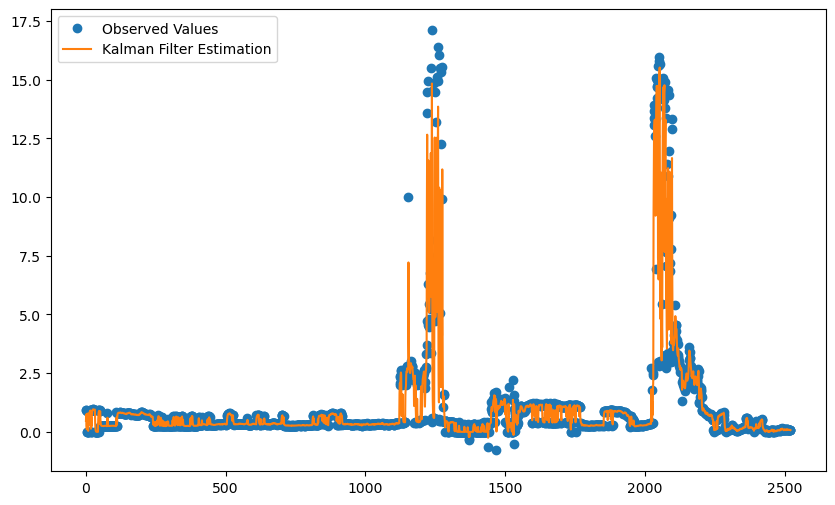

Next value prediction: 0.07490151243799617


0.4946521808603732

In [88]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = lambdas/np.mean(lambdas)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

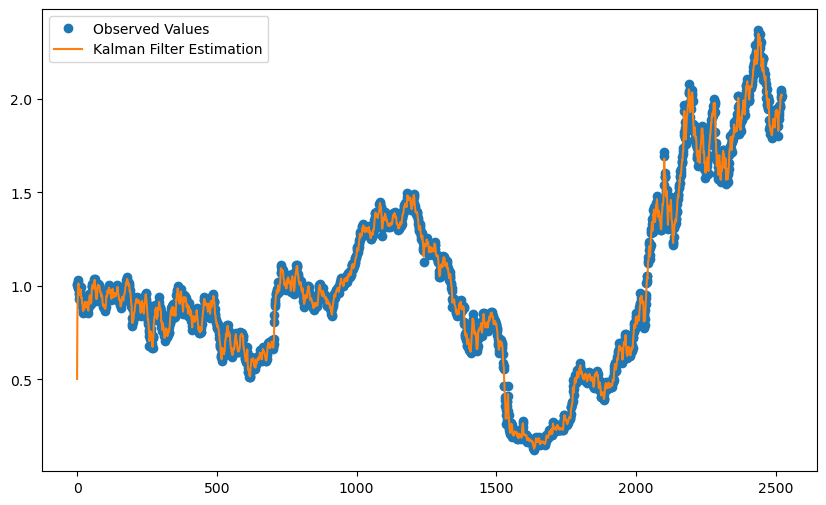

Next value prediction: 2.0194699732282326


0.9959022281879844

In [86]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_0/np.mean(beta_0)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

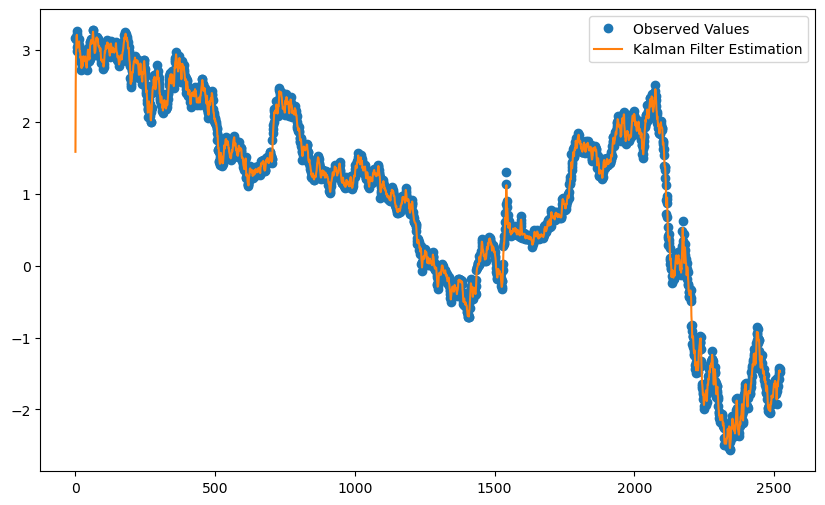

Next value prediction: -1.4745172998108036


0.9965204285858472

In [87]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_1/np.mean(beta_1)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

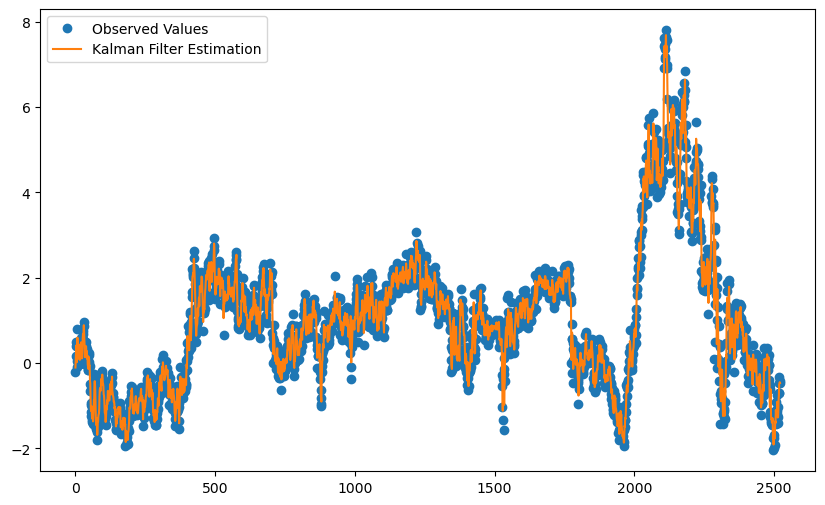

Next value prediction: -0.46415533290424327


0.9568864925336836

In [85]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_2/np.mean(beta_2)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

In [71]:
r2_score(state_means[:-1], lambdas[1:])

0.4946521808603733

In [77]:
# It seems I forgot to import numpy before using it. Let's correct that and run the function again.

import numpy as np

def moving_average_with_lag(observations, window_size=5, lag=5):
    """
    Compute the moving average of an array with a specified lag.
    
    Parameters:
    - observations: The input array of observations.
    - window_size: The size of the moving average window.
    - lag: The lag to apply after computing the moving average.
    
    Returns:
    - A numpy array containing the moving averages with the specified lag.
    """
    
    # Compute the moving average
    moving_averages = np.convolve(observations, np.ones(window_size) / window_size, mode='valid')
    
    # Apply the lag
    # Prepend np.nan (or zeros) to the start of the moving averages array to introduce the lag
    lagged_moving_averages = np.concatenate((np.full(lag, np.nan), moving_averages))
    
    # If the lag causes the result to be longer than the original, trim the excess
    if len(lagged_moving_averages) > len(observations):
        lagged_moving_averages = lagged_moving_averages[:len(observations)]
    
    return lagged_moving_averages

n = 3

# Example usage:
observations = lambdas
moving_average_with_lag_result = moving_average_with_lag(observations,n,n)

moving_average_with_lag_result
r2_score(moving_average_with_lag_result[n:], lambdas[n:])

0.5048491511019102

<Axes: >

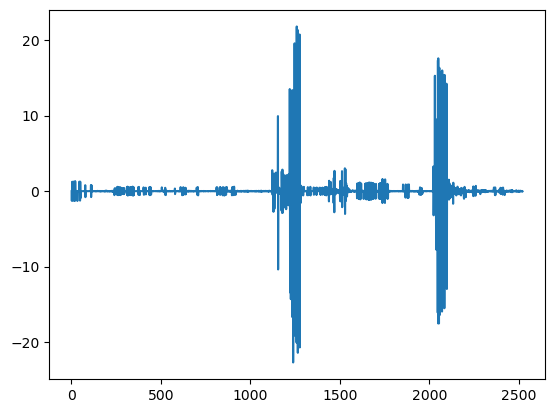

In [79]:
sample_series = pd.Series(lambdas)
sample_series.diff(1).plot()

In [66]:
r2_score(moving_average_with_lag_result[5:], lambdas[5:])

0.4453901321419629

In [39]:

# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(18,23):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_0, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [ ]:
print(bic_res)
print(aic_res)
print(combined_res)

In [ ]:
model = ARIMA(beta_1, order=(2, 1, 19), maxiter=500, method='lbfgs')
model_fit = model.fit()

# Check the summary
print(model_fit.summary())

# Optimal Beta 1

In [ ]:


# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(1,15):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_1, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


In [ ]:
combined_res

In [ ]:

model = ARIMA(beta_2, order=(2, 2, 1))  # using d=1 as found in step 1
model_fit = model.fit()
print(model_fit.summary())

# Find the optimal Parameters for Beta 1 for GARCH, FAILING so far

In [ ]:


            
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for q in range(5,25):
    # Specifying a GARCH(1, 1) model
    garch_model = arch_model(beta_1, vol='Garch', p=2, q=q)

    # Fit the model
    garch_fit = garch_model.fit(disp='off')  # disp='off' turns off the convergence output
    if garch_fit.aic < best_aic:
        aic_res =   [2,q]
        best_aic = garch_fit.aic
            
    if garch_fit.bic < best_bic:
        bic_res =  [2,q]
        best_bix = garch_fit.bic
    
    if garch_fit.bic + garch_fit.aic < combined_bic:
        combined_res =   [2,q]
        combined_bic = garch_fit.bic + garch_fit.aic


In [ ]:
print(aic_res)
print(bic_res)
print(combined_res)

In [ ]:

# Specifying a GARCH(1, 1) model
garch_model = arch_model(beta_2, vol='Garch', p=2, q=9)

# Fit the model
garch_model.fit(update_freq=5, disp='off', show_warning=True, tol=1e-6)
print(garch_fit.summary())


## Garch Model not converging

(iii) Can the yield predictions based on the time series properties of the parameters be used for profitable trading?

In [ ]:
# We need to implement a backtest here with the functions we calibrated and include train test split.

In [ ]:
# Assuming 'merged_df' is your DataFrame and it's already sorted by date
total_rows = len(merged_df)
last_20_percent_index = int(total_rows * 0.789)  # Calculate the starting index for the last 20%

# Select the last 20% of the data
backtest = merged_df.iloc[last_20_percent_index:]

backtest

In [ ]:
backtest

In [ ]:
backtest['lambda']=-1.08


In [ ]:
results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(backtest)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

(iv) Develop an ML based (using xgboost, or neural net based) frame- work of analysis of the parameters leading to a profitable strategy?

(v) Can the yield predictions based on the ML approach lead to prof- itable trading?